# Cross section computation using the Discrete Integral Transform (DIT) for rapid spectral synthesis

We demonstarte the Discrete Integral Transform (DIT) method proposed by D.C.M van den Bekerom and E.Pannier. DIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by DIT with the direct computation (LPF).  



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [2]:
from jax import config

config.update("jax_enable_x64", True)

In [17]:
from exojax.database.hitran  import line_strength
from exojax.database.hitran  import doppler_sigma
from exojax.database.hitran  import gamma_hitran
from exojax.database.hitran  import gamma_natural
from exojax.utils.grids import wavenumber_grid
from exojax.utils.constants import Tref_original
from exojax.database import api 

# Setting wavenumber bins and loading HITRAN database
nus, wav, resolution = wavenumber_grid(
    1900.0, 2300.0, 350000, unit="cm-1", xsmode="dit"
)
mdbCO = api.MdbHitran(
    "CO", nus, isotope=1, gpu_transfer=True
)  # here we use the isotope=1 (12C16O) in DIT.

# set T, P and partition function
Mmol = mdbCO.molmass
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.0e-3  # we compute P=1.e-3 bar
Ppart = Pfix  # partial pressure of CO. here we assume a 100% CO atmosphere.
qt = mdbCO.qr_interp_lines(
    Tfix, Tref_original
)  # use all isotopes as a partition function

# compute Sij, gamma_L, sigmaD
Sij = line_strength(
    Tfix, mdbCO.logsij0, mdbCO.nu_lines, mdbCO.elower, qt, Tref_original
)
gammaL = gamma_hitran(
    Pfix, Tfix, Ppart, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self
) + gamma_natural(mdbCO.A)
sigmaD = doppler_sigma(mdbCO.nu_lines, Tfix, Mmol)

xsmode =  dit
xsmode assumes ESLIN in wavenumber space: xsmode=dit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
radis engine =  vaex


DIT uses a grid of sigmaD, gammaL, and wavenumber. set_ditgrid.ditgrid_log_interval makes a 1D grid for sigmaD and gamma.

In [18]:
from exojax.opacity.set_ditgrid import ditgrid_log_interval

sigmaD_grid = ditgrid_log_interval(sigmaD)
gammaL_grid = ditgrid_log_interval(gammaL)

# we can change the resolution using res option
# sigmaD_grid=set_ditgrid(sigmaD,res=0.1)
# gammaL_grid=set_ditgrid(gammaL,res=0.1)

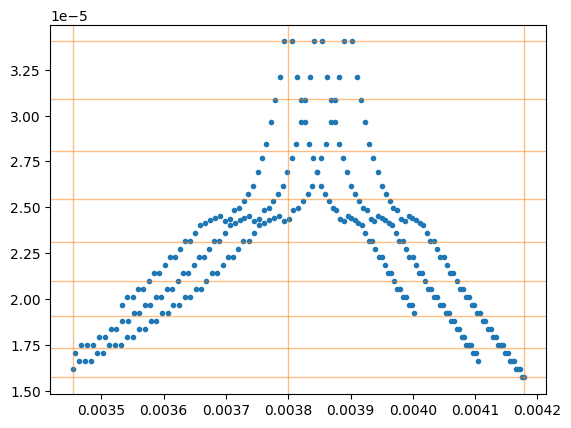

In [19]:
# show the grids
plt.plot(sigmaD, gammaL, ".")
for i in sigmaD_grid:
    plt.axvline(i, lw=1, alpha=0.5, color="C1")
for i in gammaL_grid:
    plt.axhline(i, lw=1, alpha=0.5, color="C1")

We need to precompute the contribution for wavenumber. Also, pmarray is needed. These can be computed using init_dit. 

In [20]:
from exojax.opacity import initspec

cnu, indexnu, pmarray = initspec.init_dit(mdbCO.nu_lines, nus)

Then, let's compute a cross section!

In [21]:
from exojax.opacity.dit import xsvector

xs = xsvector(cnu, indexnu, pmarray, sigmaD, gammaL, Sij, nus, sigmaD_grid, gammaL_grid)

Also, we here try the direct computation using Direct-LPF for the comparison purpose

In [22]:
from exojax.opacity.opacalc import OpaDirect
opa = OpaDirect(mdbCO, nus)
xsv = opa.xsvector(Tfix, Pfix, Ppart)

The difference is <~ 1%.

/tmp/ipykernel_809841/4022811313.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


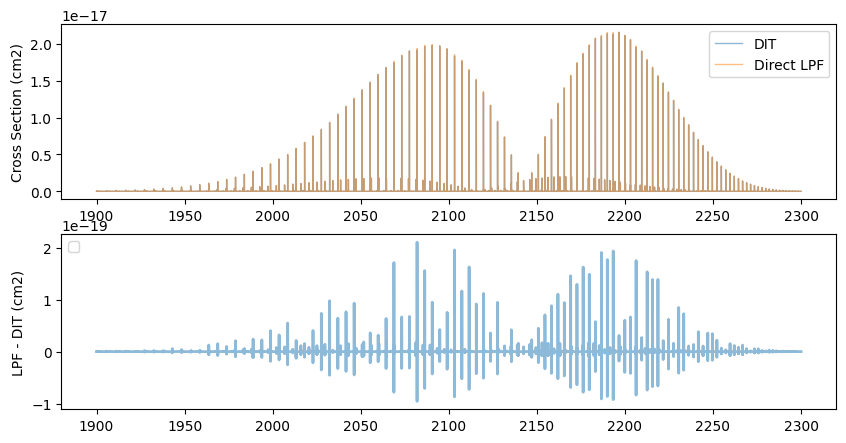

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(nus, xs, lw=1, alpha=0.5, label="DIT")
plt.plot(nus, xsv, lw=1, alpha=0.5, label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax = fig.add_subplot(212)
# plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="precomputed")
plt.plot(nus, xsv - xs, lw=2, alpha=0.5)
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()